# 15-688 Final Project: Predicting Airbnb New Listing Quality
**Team Member:** <br>
Wanni Zhang - Andrew ID: wannniz <br>
Xianla(Larry) Li - Andrew ID: xianlal




## Introduction

It is pretty hard to evaluate quality of new listings when they have few reviews and the ratings cannot relects their quality persuasively. How to help customers identify listings with good qualities is a major problem. In this project, we will apply machine learning alogorithms to solve this problem. <br>
To be more specific, the goal of our project is to learn what are the features of high quality listings on Airbnb. This will be used to predict the quality of new listings when there's no ratings from guests, which is helpful for users to make a decision whether to book the new listing or not. <br>
The report of our project will be oraganised in following parts:
 - Introduction
 - Data Scraping
 - Data Cleaning
 - Data Exploration and Problems
 - Model Selection and Parameter tuning 
 - Text analysis
 - Results and Analysis<br>
 
 <br>
 The packages and tools we will use for this project is loaded below.
 

In [21]:
import io, time, json, re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, date
import nltk
from collections import Counter
import string
nltk.download('punkt') # for google colab, no need for local use

[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data Scraping
The first step of our project is data scraping. We will refer to majorly three websits for data:
 - 

We scrape data of Airbnb listings in San Francisco (and other nearby cities) from the [unofficial API](https://stevesie.com/apps/airbnb-api). Since the only query variable is the location, and we found with a single location, the API will only scrape 300 listings each time, we decided to use several districts in San Francisco as the query input, to get as many listings as possible. By checking the listing ID, the duplicated results from the response are removed.

After parsing the response of a single query, we write a function do extract useful data from all the response

**Show an example of request results?**

In [0]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

In [0]:
def process_data(data, ids):
#     try:
#         ids = data[0]['home_tab_metadata']['remarketing_ids']
#         print(len(ids))
#     except:
#         print("Data structure issues.")
#         return 
    ans = []
    home_metadata = []
    for section in data[0]['sections']:
        if section['listings']:
            for listing in section['listings']:
                if listing['listing']['id'] not in ids:
                    ans.append(listing)
                    ids.add(listing['listing']['id'])
                    home_metadata.append(data[0]['home_tab_metadata'])
    print('listings number: ',len(ans))
    return ans, ids, home_metadata

In [0]:
def scraping_data(locations):    
    ans = []
    home_data = []
    ids = set()
    for loc in locations:
        print('Now getting: %s'%loc)
        offset = 0
        while(True):
            headers = {'Accept': 'application/json', 'Accept-Encoding': 'gzip, deflate',
               'Accept-Language':'en-us', 'Connection':'keep-alive',
               'Host':'api.airbnb.com', 'User-Agent': 'Airbnb/17.11 iPhone/10.2.1 Type/Phone',
               'X-Airbnb-API-Key': 'd306zoyjsyarp7ifhu67rjxn52tv0t20',
               'X-Airbnb-Carrier-Country':'us', 'X-Airbnb-Currency':'USD',
               'X-Airbnb-Locale':'en',
               'X-Airbnb-Network-Type':'wifi'}
            url = 'https://api.airbnb.com/v2/explore_tabs?currency=USD&items_per_grid=100&key=d306zoyjsyarp7ifhu67rjxn52tv0t20'\
            + '&location={}San%20Francisco%2C%20CA%2C%20United%20States&section_offset={}&'.format(loc,offset) \
            + 'supports_for_you_v3=true&tab_id=home_tab&timezone_offset=300&version=1.3.4'
            time.sleep(0.200)
            re = requests.get(url, headers=headers)
            data = re.json()['explore_tabs']
            listings, ids, home_metadata = process_data(data, ids)
            ans.extend(listings)
            home_data.extend(home_metadata)
            if len(listings) == 0:
                break
            elif data[0]['pagination_metadata']['has_next_page'] == True:
                offset += 1
            else:
                break
        time.sleep(1.000)
    return ans, ids, home_data

In [0]:
locations = ['North%20Beach%2C%20', 'Richmond%20District%2C%20', 'Financial%20District%2C%20',
                 'Laurel%20Heights%2C%20', 'Sunset%20District%2C%20', 'Mission%20District%2C%20', 
                 'Outer%20Mission%2C%20', 'Cow%20Hollow%2C%20', 
                 'Noe%20Valley%2C%20', 'Haight%2C%20', 'Hunters%20Point%2C%20', 'Bernal%20Heights%2C%20']
listings, ids, home_data = scraping_data(locations)

from google.colab import files # ignore this for normal jupyter notebook
with open('listings.json', 'w') as file:
    json.dump(listings, file)
files.download('listings.json') # ignore this for normal jupyter notebook
with open('home_data.json', 'w') as file:
    json.dump(home_data, file) 
files.download('home_data.json') # ignore this for normal jupyter notebook

We saved the useful results in json files. So here we just load the files to avoid scraping again. (Feel free to run the cell above if you want to try scraping yourself)

In [18]:
# Ignore this. 
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}"'.format(name=fn))
# Ignore this.

Saving listings.json to listings (1).json
User uploaded file "listings.json"


In [0]:
listings = json.loads(uploaded['listings.json'].decode("utf-8"))

The file `listings` contains data for all listings collected (2394 linstings) . 

In [20]:
print('number of listings: ', len(listings))
print(listings[0].keys())

number of listings:  2394
dict_keys(['listing', 'pricing_quote', 'verified', 'verified_card'])


There are four sections in each listing.`listing` contains the most features for the property, and `pricing_quote` contains the information for the price of the listing. `verified `and `verified_card` have information for the host. Most of the useful information is stored in the first two sections. The features are showed as follows.

In [21]:
print(listings[0]['listing'].keys())
print(listings[0]['pricing_quote'].keys())

dict_keys(['badges', 'bathroom_label', 'bathrooms', 'bed_label', 'bedroom_label', 'bedrooms', 'beds', 'city', 'detailed_rating', 'guest_label', 'host_languages', 'host_thumbnail_url_small', 'host_thumbnail_url', 'id', 'is_business_travel_ready', 'is_fully_refundable', 'is_host_highly_rated', 'is_new_listing', 'is_rebookable', 'is_superhost', 'kicker_content', 'lat', 'lng', 'localized_city', 'localized_neighborhood', 'main_section_message', 'name', 'neighborhood', 'person_capacity', 'picture_count', 'picture_url', 'picture_urls', 'picture', 'preview_amenities', 'preview_encoded_png', 'property_type_id', 'reviews_count', 'room_and_property_type', 'room_type_category', 'room_type', 'scrim_color', 'show_structured_name', 'space_type', 'star_rating', 'tier_id', 'user'])
dict_keys(['can_instant_book', 'monthly_price_factor', 'price', 'price_string', 'rate', 'rate_type', 'rate_with_service_fee', 'weekly_price_factor'])


From all the information provided, we selected some features that are most relevant for evaluating the quality of the listing, including features about the property itself, it's neighborhood, and the host. The function below extracts the features from all listings and stored them in a dataframe.


In [0]:
def extract_listing_features(listings):
    d = {'host_id':[],'has_profile_pic':[],'can_instant_book':[],'price':[],'rate_type':[]}
    feature_names = ['id', 'bathrooms', 'bedrooms', 'beds', 'person_capacity', 'is_fully_refundable',
                     'room_and_property_type', 'room_type_category','city', ''
                     'is_host_highly_rated', 'is_superhost', 'is_new_listing', 'neighborhood', 
                     'property_type_id', 'tier_id', 'picture_count', 'preview_amenities', 'star_rating']
    host_features = ['host_id', 'first_name', 'has_profile_pic']
    for i, home in enumerate(listings):
        for feature in feature_names:
            if feature not in d:
                d[feature] = []
            d[feature].append(home['listing'][feature])
        d['host_id'].append(home['listing']['user']['id'])
        d['has_profile_pic'].append(home['listing']['user']['has_profile_pic'])
        d['can_instant_book'].append(home['pricing_quote']['can_instant_book'])
        d['price'].append(home['pricing_quote']['rate_with_service_fee']['amount'])
        d['rate_type'].append(home['pricing_quote']['rate_type'])
    df = pd.DataFrame.from_dict(d)
    return df

The features we extracted are as follows and the `star_rating` is the label to predict for each listing.

In [79]:
df = extract_listing_features(listings)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394 entries, 0 to 2393
Data columns (total 23 columns):
bathrooms                 2385 non-null float64
bedrooms                  2394 non-null int64
beds                      2393 non-null float64
can_instant_book          2394 non-null bool
city                      2394 non-null object
has_profile_pic           2394 non-null bool
host_id                   2394 non-null int64
id                        2394 non-null int64
is_fully_refundable       2394 non-null bool
is_host_highly_rated      2394 non-null bool
is_new_listing            2394 non-null bool
is_superhost              2394 non-null bool
neighborhood              2394 non-null object
person_capacity           2394 non-null int64
picture_count             2394 non-null int64
preview_amenities         2394 non-null object
price                     2394 non-null int64
property_type_id          2394 non-null int64
rate_type                 2394 non-null object
room_and_property

Clearly, there are some missing values in the feature `beds`, `bathrooms` and `star_ratings`, so we remove the listings with missing value.



In [80]:
df = df[pd.notnull(df['beds'])]
df = df[pd.notnull(df['bathrooms'])]
df = df[pd.notnull(df['star_rating'])]
df = df.reset_index(drop=True)
df.isnull().any()

bathrooms                 False
bedrooms                  False
beds                      False
can_instant_book          False
city                      False
has_profile_pic           False
host_id                   False
id                        False
is_fully_refundable       False
is_host_highly_rated      False
is_new_listing            False
is_superhost              False
neighborhood              False
person_capacity           False
picture_count             False
preview_amenities         False
price                     False
property_type_id          False
rate_type                 False
room_and_property_type    False
room_type_category        False
star_rating               False
tier_id                   False
dtype: bool

In [81]:
df.head()

,bathrooms,bedrooms,beds,can_instant_book,city,has_profile_pic,host_id,id,is_fully_refundable,is_host_highly_rated,is_new_listing,is_superhost,neighborhood,person_capacity,picture_count,preview_amenities,price,property_type_id,rate_type,room_and_property_type,room_type_category,star_rating,tier_id
0,1.0,1,1.0,True,San Francisco,True,1569866,18656474,False,True,False,True,Telegraph Hill,2,6,"Wifi, Kitchen, Hair dryer",110,1,nightly,Private room in apartment,private_room,5.0,0
1,1.0,1,1.0,False,San Francisco,True,136792470,19591783,False,True,False,False,Telegraph Hill,2,6,"Wifi, Hair dryer",132,67,nightly,Private room in tiny house,private_room,5.0,0
2,1.0,1,1.0,False,San Francisco,True,31531759,6074750,False,False,False,True,Telegraph Hill,2,10,"Wifi, Hair dryer",99,2,nightly,Private room in house,private_room,4.5,0
3,1.0,1,1.0,True,San Francisco,True,136470616,20936337,False,True,False,True,Telegraph Hill,2,8,"Wifi, Kitchen, Hair dryer",69,1,nightly,Private room in apartment,private_room,4.5,0
4,1.0,1,1.0,True,San Francisco,True,6796236,21459964,False,True,False,False,Telegraph Hill,1,9,"Wifi, Kitchen, Hair dryer",176,37,nightly,Private room in condominium,private_room,5.0,0


There are still some features in the dataframe that need processing. First we review the categorical features. Since for some classifiers, the cateorical features need be binarized (one-hot encoding), but when the number of category is large, it's not appropiate to do one-hot encoding or there will be too many sparse features.

In [82]:
print('city:', df['city'].unique())
print('neighborhood:', df['neighborhood'].unique())
print('preview_amenities:', df['preview_amenities'].unique())
print('rate_type:', df['rate_type'].unique())
print('property_type_id:', df['property_type_id'].unique())
print('room_type_category:', df['room_type_category'].unique())
print('tier_id:', df['tier_id'].unique())

city: ['San Francisco' 'Daly City' 'San bruno']
neighborhood: ['Telegraph Hill' 'North Beach' 'Financial District' 'Presidio'
 'Richmond District' 'Western Addition/NOPA' 'Presidio Heights'
 'Pacific Heights' 'Cow Hollow' 'South Beach' 'Marina' 'Outer Sunset'
 'Inner Sunset' 'Twin Peaks' 'Cole Valley' 'Haight-Ashbury'
 'Mission District' 'SoMa' 'Bayview' 'Potrero Hill' 'Dogpatch'
 'Mission Bay' 'Excelsior' 'Mission Terrace' 'Daly City' 'Bernal Heights'
 'Visitacion Valley' 'Glen Park' 'Sunnyside' 'Portola' "Fisherman's Wharf"
 'Russian Hill' 'The Castro' 'Noe Valley' 'Duboce Triangle' 'Hayes Valley']
preview_amenities: ['Wifi, Kitchen, Hair dryer' 'Wifi, Hair dryer' 'Wifi, Kitchen' 'Wifi'
 'Free parking on premises, Wifi, Kitchen, Hair dryer' ''
 'Free parking on premises, Wifi, Kitchen'
 'Free parking on premises, Wifi, Hair dryer' 'Kitchen, Hair dryer'
 'Free parking on premises, Wifi' 'Kitchen']
rate_type: ['nightly']
property_type_id: [ 1 67  2 37  3 53 40 36 47 45 43 56 33  6 35 4

So, for `city`,` room_type_category`, and `tier_id`, we can do one-hot encoding directly, and for `rate_type`, since there's only one type, we can remove this feature. For `preview_amenities`, only four amenties show up, so we can process the string and convert this feature into three features of bool type: has_Wifi, has_kitchen, has_Free parking on premises and has_hair dryer, plus one numeric feature: num_of_preview_amenities. There are too many categories in `property_type_id` and `neighborhood`, so we need to do some feature engineering for these two features. 

In [0]:
# process the amenities
A = pd.Series([tuple(s.split(', ')) if s else () for s in df['preview_amenities']])
B = A.apply(lambda x: len(x)).rename('amenities_num')
wifi = A.apply(lambda a: 'Wifi' in a).rename('wifi')
parking = A.apply(lambda a: 'Free parking on premises' in a).rename('free_parking')
kitchen = A.apply(lambda a: 'Kitchen' in a).rename('kitchen')
hair_dryer = A.apply(lambda a: 'Hair dryer' in a).rename('hair_dryer')
amenities = pd.concat([B, wifi, parking, kitchen, hair_dryer], axis=1)
df2 = pd.concat([df, amenities], axis=1)

For `property_type_id`, we extract the name for each property type from the feature  `room_and_property_type` and try to classify these property types into a few categories based on some feature

In [0]:
def get_property(df):
    df['room_and_property_type'] = df['room_and_property_type'].apply(lambda x: x.lower())
    properties = []
    for i in range(len(df)):
        t = df['room_and_property_type'].iloc[i]
        if t.find(' in ') != -1:
            properties.append(t.split(' in ')[1])
        elif t.find(' ') != -1:
            s = t.split(' ',1)[0]
            if s.startswith('private') or s.startswith('entire') or s.startswith('shared'):
                properties.append(t.split(' ', 1)[1])
            else:
                properties.append(t)
        else:
            properties.append(t)
    properties = pd.Series(properties).rename('property_type')
    return pd.concat([df,properties], axis=1)

df2 = get_property(df2)

Let's check whether the name of property and the property_id is a one-to-one correspondence.

In [92]:
property_dict = {}
for i in df2.index:
    ptype = df2['property_type'].loc[i]
    pid = df2['property_type_id'].loc[i]
    if pid in property_dict:
        if property_dict[pid] != ptype:
            print(property_dict[pid],' --> ', ptype)
    else:
        property_dict[pid] = ptype

room  -->  place
room  -->  place
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
bed and breakfast  -->  bed & breakfast
room  -->  place
bed and breakfast  -->  bed & breakfast
room  -->  place


So basically we interpret the property type correctly (the 'room' and 'place' are for 'private room' and 'private place'). Then we classify the types into three classes: basic, quality and premium, based on their quality.

In [93]:
df2['property_type'].unique()

array(['apartment', 'tiny house', 'house', 'condominium',
       'bed and breakfast', 'guest suite', 'guesthouse', 'townhouse',
       'serviced apartment', 'hostel', 'boutique hotel', 'aparthotel',
       'room', 'treehouse', 'loft', 'hotel', 'resort', 'place',
       'bungalow', 'cabin', 'cottage', 'floor', 'bed & breakfast',
       'villa', 'castle'], dtype=object)

In [0]:
basic = ['bed and breakfast','room','loft','hostel','place','cabin','floor','bed & breakfast',
         'treehouse','bungalow','cottage','tiny house']
quality = ['apartment','house','condominium','guest suite', 'guesthouse','townhouse','aparthotel','hotel']
premium = ['serviced apartment','boutique hotel','villa', 'castle','resort']

def replace_property(p):
    return 'basic' if p in basic else 'quality' if p in quality else 'premium'

df2['property_type'] = df2['property_type'].apply(replace_property)

In [0]:
# drop the useless columns
# 'is_fully_refundable' contains only False, so dropped
df_clean = df2.drop(columns=['rate_type','is_fully_refundable', 'room_and_property_type',
                             'property_type_id','preview_amenities'])

**Convert `Neighborhood` to numerical values**


`Neighborhood` is one of the most important attributes in listings. As we said, we found there are over 30 unique categories in our this feature. Thus, we considered the possible impact of `Neighborhood` and decided to interpreted it as four attributes: `walk_score`, `transit_socre`, `bike_score` and `crime_rate`. We mannally checked the scores on [walkscore](https://www.walkscore.com/) and [crimemapping](https://www.crimemapping.com/) given that the workload is smaller than wrting a scraper to get the data. The unique values in `neighborhood` is shown below.

```
array(['Telegraph Hill', 'North Beach', 'Financial District', 'Presidio',
       'Richmond District', 'Western Addition/NOPA', 'Presidio Heights',
       'Pacific Heights', 'Cow Hollow', 'South Beach', 'Marina',
       'Outer Sunset', 'Inner Sunset', 'Twin Peaks', 'Cole Valley',
       'Haight-Ashbury', 'Mission District', 'SoMa', 'Bayview',
       'Potrero Hill', 'Dogpatch', 'Mission Bay', 'Excelsior',
       'Mission Terrace', 'Daly City', 'Bernal Heights',
       'Visitacion Valley', 'Glen Park', 'Sunnyside', 'Portola',
       "Fisherman's Wharf", 'Russian Hill', 'The Castro', 'Noe Valley',
       'Duboce Triangle', 'Hayes Valley'], dtype=object)
```



In [0]:
n_rates = dict()
# values in tuple (walk_score, transit_score, bike_score, crime_rate)
n_rates['Telegraph Hill'] = (99, 96, 61, 108)
n_rates['North Beach'] = (99, 96, 71, 109)
n_rates['Financial District'] = (95, 100, 84, 142)
n_rates['Presidio'] = (90, 76, 77, 1)
n_rates['Richmond District'] = (92, 78, 94, 38)
n_rates['Western Addition/NOPA'] = (96, 89, 92, 128)
n_rates['Presidio Heights'] = (90, 76, 77, 19)
n_rates['Pacific Heights'] = (96, 89, 66, 57)
n_rates['Cow Hollow'] = (93, 77, 65, 58)
n_rates['South Beach'] = (89, 100, 88, 164)
n_rates['Marina'] = (92, 76, 81, 48)
n_rates['Outer Sunset'] = (78, 62, 76, 10)
n_rates['Inner Sunset'] = (94, 72, 83, 27)
n_rates['Twin Peaks'] = (33, 71, 47, 22)
n_rates['Cole Valley'] = (96, 77, 90, 34)
n_rates['Haight-Ashbury'] = (96, 81, 91, 51)
n_rates['Mission District'] = (97,89, 98, 173)
n_rates['SoMa'] = (95, 100, 97, 237)
n_rates['Bayview'] = (82, 68, 62, 34)
n_rates['Potrero Hill'] = (87, 74, 76, 55)
n_rates['Dogpatch'] = (71, 74, 92, 22)
n_rates['Mission Bay'] = (89, 88, 96, 17)
n_rates['Excelsior'] = (79, 78, 62, 32)
n_rates['Mission Terrace'] = (80, 85, 74, 31)
n_rates['Daly City'] = (63, 0, 0, 0)
n_rates['Bernal Heights'] = (88, 77, 75, 39)
n_rates['Visitacion Valley'] = (68, 67, 50, 22)
n_rates['Glen Park'] = (78, 81, 59, 26)
n_rates['Sunnyside'] = (78, 80, 59, 10)
n_rates['Portola'] = (76, 69, 67, 30)
n_rates["Fisherman's Wharf"] = (97, 89, 87, 59)
n_rates['Russian Hill'] = (96, 94, 63, 79)
n_rates['The Castro'] = (95, 95, 72, 62)
n_rates['Noe Valley'] = (91, 74, 78, 78)
n_rates['Duboce Triangle'] = (98, 99, 88, 162)
n_rates['Hayes Valley'] = (97, 99, 92, 149)

Then assign these values to dataset.

In [0]:
df_clean = df_clean.assign(walk_score = df_clean.neighborhood.apply(lambda x: n_rates[x][0]),
               transit_score = df_clean.neighborhood.apply(lambda x: n_rates[x][1]),
               bike_score = df_clean.neighborhood.apply(lambda x: n_rates[x][2]),
               crime_score = df_clean.neighborhood.apply(lambda x: n_rates[x][3]))
df_clean = df_clean.drop(columns=['neighborhood'])

We also add another feature: the average rating of other listings belonging to the same host, which reflects the reliability of the host.

In [0]:
df_clean = df_clean.assign(host_other_rating = lambda x: \
                           (df_clean[df_clean.host_id==x.host_id]['star_rating'].sum()-x.star_rating)\
                           /(len(df_clean[df_clean.host_id==x.host_id]['star_rating'])-1)\
                           if len(df_clean[df_clean.host_id==x.host_id]['star_rating']) != 0 else avg_rating
                          )

Finally we do one-hot encoding for all categorical data and the dataframe we use to train the model is like this:

In [146]:
df_final = pd.get_dummies(df_clean, columns = ['city', 'room_type_category','property_type','tier_id'], 
               prefix=['city','','property_type', 'tier'], prefix_sep=['_','','_', '_'])
df_final.head()

,bathrooms,bedrooms,beds,can_instant_book,has_profile_pic,host_id,id,is_host_highly_rated,is_new_listing,is_superhost,person_capacity,picture_count,price,star_rating,amenities_num,wifi,free_parking,kitchen,hair_dryer,walk_score,transit_score,bike_score,crime_score,host_other_rating,city_Daly City,city_San Francisco,city_San bruno,entire_home,private_room,shared_room,property_type_basic,property_type_premium,property_type_quality,tier_0,tier_1
0,1.0,1,1.0,True,True,1569866,18656474,True,False,True,2,6,110,5.0,3,True,False,True,True,99,96,61,108,4.842080,0,1,0,0,1,0,0,0,1,1,0
1,1.0,1,1.0,False,True,136792470,19591783,True,False,False,2,6,132,5.0,2,True,False,False,True,99,96,61,108,4.842080,0,1,0,0,1,0,1,0,0,1,0
2,1.0,1,1.0,False,True,31531759,6074750,False,False,True,2,10,99,4.5,2,True,False,False,True,99,96,61,108,4.842317,0,1,0,0,1,0,0,0,1,1,0
3,1.0,1,1.0,True,True,136470616,20936337,True,False,True,2,8,69,4.5,3,True,False,True,True,99,96,61,108,4.842317,0,1,0,0,1,0,0,0,1,1,0
4,1.0,1,1.0,True,True,6796236,21459964,True,False,False,1,9,176,5.0,3,True,False,True,True,99,96,61,108,4.842080,0,1,0,0,1,0,0,0,1,1,0


## Data Mining and Problems

**Convert to Binary**<br>
By inspecting our label `star_rating`, we found that the precision of the rating is only 0.5 (half-star), and most of the listings have a rating of 5-star. The number of instancs in most groups is less than 10.

In [124]:
df_clean['star_rating'].unique()

array([5. , 4.5, 4. , 3.5, 3. , 2. ])

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        3.000e+00, 8.000e+00, 4.000e+01, 5.460e+02, 1.518e+03]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5]),
 <a list of 11 Patch objects>)

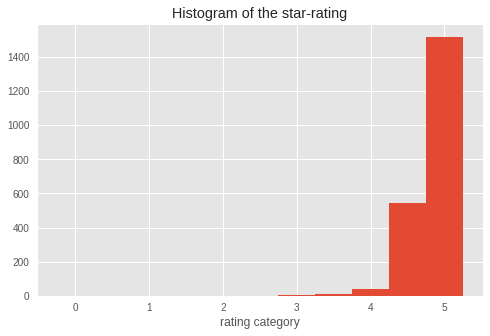

In [125]:
plt.figure(figsize=(8,5))
plt.xlabel('rating category')
plt.title('Histogram of the star-rating')
plt.hist(df_clean['star_rating'], bins=11, range=(0,5.5), align='left')

So we decide to change the problem to a binary classification. Only the listings with 5-star rating are considered 'good listings', and others are all 'bad listings'. Since the main purpose of the prediction is to help guests avoid bad listings, we label bad listings as True.  

After binarized, it's still a very biased dataset, so we use the SMOTE (Synthetic Minority Oversampling Technique) algorithm to oversampling the class of bad_listings.

In [0]:
y = df_clean['star_rating']<6
X = df_clean.drop(columns=['star_rating', 'host_id', 'id'])

In [130]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn import metrics
!pip install imblearn
from imblearn.over_sampling import SMOTE
from numpy.random import permutation

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import utils
from keras.wrappers.scikit_learn import KerasClassifier

    100% |████████████████████████████████| 153kB 4.3MB/s 


Using TensorFlow backend.


For SMOTE algorithm, we use the package `imblearn`. Since we want to implement SMOTE, we wirte our own cross validation function here.

In [0]:
def cv(X,y,clfs,k=6,smote=True):
    n = len(y)
    idx_shuffle = permutation(n)
    # self-implemented 5 folder cv
    idx_all = set(idx_shuffle)
    acc = np.zeros((k,len(clfs)))
    precisions = np.zeros((k,len(clfs)))
    recalls = np.zeros((k,len(clfs)))
    for i in range(k):
        # select continuous features to do normalization
        con_features = X[['bathrooms','bedrooms','beds','person_capacity', 'price', 'amenities_num',
                                'host_other_rating','crime_score','transit_score','walk_score']]
        disc_features = X.drop(columns=['bathrooms','bedrooms','beds','person_capacity', 'price', 'amenities_num',
                                              'host_other_rating','crime_score','transit_score','walk_score'])
        # train_validation split
        idx_v = idx_shuffle[n//k*i:n//k*(i+1)]
        idx_train = list(idx_all-set(idx_v))
        scaler = StandardScaler()
        scaler.fit(con_features.iloc[idx_train])
        # normalize data
        features_std_tr = scaler.transform(con_features.iloc[idx_train])
        X_train = np.hstack((features_std_tr, disc_features.iloc[idx_train]))
        y_train = y.iloc[idx_train]
        features_std_v = scaler.transform(con_features.iloc[idx_v])
        X_v = np.hstack((features_std_v, disc_features.iloc[idx_v]))
        y_v = y.iloc[idx_v]
        # do SMOTE for imbalanced data
        if smote:
            sm = SMOTE(ratio='minority', random_state=42)
            X_train, y_train = sm.fit_sample(X_train, y_train)
        # train each classifier
        accuracy = np.zeros(len(clfs))
        precision = np.zeros(len(clfs))
        recall = np.zeros(len(clfs))
        for clf in clfs:
            clf.fit(X_train, y_train)
            prediction = clf.predict(X_v)
            if isinstance(clf, KerasClassifier):
                prediction = prediction.flatten()
            accuracy[j] += sum(prediction==y_v)/len(y_v)
            precision[j] = np.logical_and(prediction, y_v).sum()/(prediction==True).sum()
            recall[j] = np.logical_and(prediction, y_v).sum()/(y_v==True).sum()
        acc[i] = accuracy
        precisions[i] = precision
        recalls[i] = recall
        clfs = [clone(c) for c in clfs]
    return acc, precisions, recalls

We test six classifiers: random forest, KNN, logistic regression, gradient boosting, SVM and artificial neural network (from Keras)

In [0]:
def ANN_model():
    model = Sequential()
    model.add(Dense(50, input_dim=27, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

We first divide the whole dataset into training set (80%) and testing set(20%), then we do 5-folder classification on the training set.

In [0]:
N = len(X)
idx_shuffle = permutation(N)
X_test = X.iloc[idx_shuffle[:N//5]]
y_test = y.iloc[idx_shuffle[:N//5]]
X_train = X.iloc[idx_shuffle[N//5:]]
y_train = y.iloc[idx_shuffle[N//5:]]

In [145]:
clf_names = ['random forest', 'KNN', 'logistic regression', 'gradient boosting', 'SVM', 'ann']
forest = RandomForestClassifier(n_estimators = 50, max_depth=4, class_weight=None)
knn = KNeighborsClassifier(n_neighbors=5)
logreg = LogisticRegression(C=1e5, penalty='l2')
grb = GradientBoostingClassifier(n_estimators = 50,learning_rate=0.1, max_depth=4)
svm = SVC(kernel='linear', C=0.8)
ann = KerasClassifier(build_fn=ANN_model, epochs=80, batch_size=32, verbose=0)
clfs = [forest, knn, logreg, grb, svm, ann]
accuracy, precisions, recalls = cv(X_train, y_train, clfs, k=6, smote=False)
accuracy_r, precisions_r, recalls_r = cv(X_train, y_train, clfs,k=6, smote=True)

ValueError: ignored

In [0]:
y = df['star_rating']<6

### Reconsider GOOD QUALITY Problem
According to the results above, we still found there is a major imbalance in data. This lead us to rethink the requirements for good listings. We think rating alone cannot reflect the quality of listings because for some listings, if they have few reviews they are more likely to get an overall 5 rating. Thus, the number of reviews also matters in our case. It shows the popularity of the listing. However, this is not fair for relatively new listings in our data. Thus, we decied to move on with `number_of_reviews` in last year as the reference of popularity. <br>
To do this, we first scraped `reviews` data of each listings in our dataset. 

In [0]:
# code for scraping reviews 
ids = df_clean.id
reviews = []
for i, list_id in enumerate(ids):
    url = 'https://api.airbnb.com/v2/reviews?_format=for_mobile_client&_limit=20&_offset=0&listing_id={}&role=all'.format(list_id)
    headers = {'Accept':'application/json', 'Accept-Encoding':'gzip, deflate',
       	'User-Agent':'Airbnb/16.41 iPhone/10.0.3 Type/Phone', 'X-Airbnb-API-Key':'d306zoyjsyarp7ifhu67rjxn52tv0t20',
       	'X-Airbnb-Currency':'USD', 'X-Airbnb-Locale':'en', 'X-Airbnb-Network-Type':'wifi'}
    time.sleep(0.1)
    if i % 100 == 0:
        print('now scraping %d th: %d'% (i, list_id))
    re = requests.get(url, headers=headers)
    review = re.json()
    reviews.append(review)

Feel free to fun above code but we will not run it here. We have scrape it and store them in a `json` file.

In [0]:
reviews = json.loads(uploaded['reviews.json'].decode("utf-8"))

In the `reviews` list, each element is a dictionary with all the review data of a listing. The data has a relatively complex structure and codes below shows how to access the first `review` of first listing in the listings. We will use `'created at'` here to get the counts in last year.


In [29]:
review = reviews[0]['reviews'][0]
review

{'author': {'first_name': 'Christine',
  'has_profile_pic': True,
  'id': 40593859,
  'picture_url': 'https://a0.muscache.com/im/users/40593859/profile_pic/1438786176/original.jpg?aki_policy=profile_x_medium',
  'smart_name': 'Christine',
  'thumbnail_url': 'https://a0.muscache.com/im/users/40593859/profile_pic/1438786176/original.jpg?aki_policy=profile_small'},
 'author_id': 40593859,
 'can_be_edited': False,
 'collection_tag': None,
 'comments': "Tian is the absolutely nicest host you will have. He dropped everything to accommodate me, making sure I can check in anytime I needed, and delivering keys by hand! He also mailed back my iPhone charger as soon as I made the request!! He is also very helpful with great recommendations. \n\nThe apartment has much of what you will need. It's smack between Chinatown and Little Italy, so those will be your main walkable food options. It's full of cafes, restaurants, bars and laundromats. A beautiful park is also a few minutes walk away. Great fo

In [0]:
def get_recent_counts(reviews):
    """ Get the counts of reviews for the listings.
    Inputs:
        reviews - a list of dicts with each contains review info for a listing
    Outputs:
        ans - a list of counts for listings(the same length as listings)
    """
    n = 0
    ans = []
    t_min = date(2017, 5, 9)
    for review in reviews:
        min_t = datetime.now().date()
        count = 0
        for r in review['reviews']:
            t = datetime.strptime(r['created_at'][0:10], '%Y-%m-%d').date()
            if t > t_min:
                count += 1
        ans.append(count)
    return ans

recent_counts = get_recent_counts(reviews)

Then we append the list to the dataset.

In [31]:
df_clean = df_clean.assign(review_counts=counts)

NameError: ignored

The histogram of `count_of_review`.

In [0]:
df_clean.review_counts.hist()

## Resuts and Anlysis
Through model selection and parameter tuning, we found that Random Forest has the best performance over others. 

### Word Cloud  <br>
Since we have scraped the review data from Airbnb, we think the content of reviews can also be helpful to identify good listings. Thus, all the texts are tokenized and analyzed. We did a word cloud for both good listings and bad listings according to rating of the review.<br>
To be specific, reviews for listings are in 5 scale rating with 5 the best, and 1 the worst. We only consider 5 as good listings and all the others as bad listings because people always give ratings below 5 for some reason that makes them not comfortable during their stay there. The code used to process listings are shown below. The general procedures are:
-  tokenized the text
- made two counters for good words and bad words
- removed stop words and rarewords in the counter
- identified indicator words and their counts 
- drew word cloud for both good words and bad words

In [0]:
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    ans = []
    new_text = text.lower()
    new_text = new_text.replace("'s", "")
    new_text = new_text.replace("'", "")
    for p in string.punctuation:
        new_text = new_text.replace(p, " ")
    tokens = nltk.word_tokenize(new_text)
    for token in tokens:
        try:
            temp = lemmatizer.lemmatize(token)
        except:
            continue
        ans.append(temp)
    return ans

def get_rare_words(review_text):
    """ Find rare words in review texts
    Inputs:
        list of reviewe text
    Outputs:
        list(str): list of rare words, sorted alphabetically.
    """
    count = Counter()
    ans = []
    for text in review_text:
        count.update(text)
    for key in count:
        if count[key] == 1:
            ans.append(key)
    return sorted(ans)

def process_all(reviews):
    """ Process all reviews and return a list of review texts and ratings
    Inputs:
        reivews - a list of reviews with each review a dict scraped
    Outputs:
        ans - a list of reviwe texts
        ratings - a list of review ratings
    """
    ans = []
    ratings = []
    for review in reviews:
        for r in review['reviews']:
            ans.append(process(r['comments']))
            ratings.append(r['rating'])
    return ans, ratings

def word_cloud(reviews):
    """ Process all reviews to get counters of good words and bad words
  Inputs:
      reviews - a list of reviws with each review a dict scraped
  Outputs:
      good - a counter of good words
      bad - a counter of bad words
    """
    review_text, ratings = process_all(reviews)
    rare_words = get_rare_words(review_text)
    stop_words = nltk.corpus.stopwords.words('english')
    stop_words.extend(rare_words)
    
    good = Counter()
    bad = Counter()
    for rating, text in zip(ratings, review_text):
        if rating == 5:
            good.update(text)
        else:
            bad.update(text)
    for word in stop_words:
        good[word], bad[word] = 0, 0
    return good, bad

def get_indicator(good, bad):
    """ Get indicator words from counters of good words and bad words
  Inputs:
      good - a counter of good words
      bad - a counter of bad words
  Ouputs:
      g - a counter of good indicator words
      b - a counter of bad indicator words
    """
    up = 20
    low = 20
    g, b = Counter(), Counter()
    for key in good:
        if good[key]>up and bad[key]<low:
            g[key] = good[key]
        elif bad[key]>up and good[key]<up:
            b[key] = bad[key]
    return g, b

Then we load our `reviews` and process them to see the results

In [15]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}"'.format(name=fn))

Saving reviews.json to reviews.json
User uploaded file "reviews.json"


In [0]:
reviews = json.loads(uploaded['reviews.json'].decode("utf-8"))
good, bad = word_cloud(reviews)
g, b = get_indicator(good, bad)
print('good words:', len(g), 'bad words:', len(b))
print('good: ', [x[0] for x in g.most_common(20)])
print('bad: ', [x[0] for x in b.most_common(20)])

From the results we can see that words in `good`are much more than  those in `bad`. From here we can tell that there are tons of reasons for a listing to be good while low ratings usually have similar reasons. This could be used to help hosts to improve their listings' quality or service quality. <br>
At the same time, there are some names in good words. This means the good hosts might similar names. However, this should be confirmed with the overall distribution of the hosts' names. <br>
At last, we saved our words into raw text files and used a [online tool](https://www.jasondavies.com/wordcloud/) to create word clouds for both good words and bad words. 

In [0]:
s = ''
for x in b:
    temp = '%s '% x
    s += b[x]*temp
textfile = open('textfile1.txt', 'w', encoding='utf-8')
textfile.write(s)
textfile.close()
s = ''
for x in g:
    temp = '%s '% x
    s += g[x]*temp
textfile = open('textfile1.txt', 'w', encoding='utf-8')
textfile.write(s)
textfile.close()

The word coulds are shown below.<br>
**Word cloud for good words**
![alt text](https://i.imgur.com/P9FI17s.png)
**Word cloud of bad words**
![alt text](https://i.imgur.com/0gwZiV9.png)